In [1]:
import pandas as pd
import numpy as np

import boto3
import pyarrow.parquet as pq

import matplotlib.pyplot as plt
import io
import os

import datetime
from getpass import getpass

import warnings
warnings.filterwarnings('ignore')

In [2]:
AWS_S3_BUCKET = "pipeliner-hb"
AWS_ACCESS_KEY_ID = getpass("AWS_ACCESS_KEY_ID: ")
AWS_SECRET_ACCESS_KEY = getpass("AWS_SECRET_ACCESS_KEY: ")

In [3]:
def pd_read_s3_parquet(key, bucket, s3_client=None, **args):
    if s3_client is None:
        s3_client = boto3.client('s3')
    obj = s3_client.get_object(Bucket=bucket, Key=key)
    return pd.read_parquet(io.BytesIO(obj['Body'].read()), **args)

def pd_read_s3_multiple_parquets(filepath, bucket, s3=None, 
                                 s3_client=None, verbose=False, **args):
    if not filepath.endswith('/'):
        filepath = filepath + '/'  # Add '/' to the end
    if s3_client is None:
        s3_client = boto3.client('s3')
    if s3 is None:
        s3 = boto3.resource('s3')
    s3_keys = [item.key for item in s3.Bucket(bucket).objects.filter(Prefix=filepath)
               if item.key.endswith('.parquet')]
    if not s3_keys:
        print('No parquet found in', bucket, filepath)
    elif verbose:
        print('Load parquets:')
        for p in s3_keys: 
            print(p)
    dfs = [pd_read_s3_parquet(key, bucket=bucket, s3_client=s3_client, **args) 
           for key in s3_keys]
    return pd.concat(dfs, ignore_index=True)

In [4]:
df = pd.DataFrame()
for day in range(11, 31):
    path = f'data/parquet/2022-07-{day:02}'
    print(f"Reading {path} ...")
    temp_df = pd_read_s3_multiple_parquets(path, AWS_S3_BUCKET)
    df = df.append(temp_df)

df

Reading data/parquet/2022-07-11 ...
Reading data/parquet/2022-07-12 ...
Reading data/parquet/2022-07-13 ...
Reading data/parquet/2022-07-14 ...
Reading data/parquet/2022-07-15 ...
Reading data/parquet/2022-07-16 ...
Reading data/parquet/2022-07-17 ...
Reading data/parquet/2022-07-18 ...
Reading data/parquet/2022-07-19 ...
Reading data/parquet/2022-07-20 ...
Reading data/parquet/2022-07-21 ...
Reading data/parquet/2022-07-22 ...
Reading data/parquet/2022-07-23 ...
Reading data/parquet/2022-07-24 ...
Reading data/parquet/2022-07-25 ...
Reading data/parquet/2022-07-26 ...
Reading data/parquet/2022-07-27 ...
Reading data/parquet/2022-07-28 ...
Reading data/parquet/2022-07-29 ...
Reading data/parquet/2022-07-30 ...


,datetime,open,high,low,close,volume
0,2022-07-11 00:00:00,20861.11,20868.48,20814.79,20818.54,245.10550
1,2022-07-11 00:01:00,20818.54,20839.66,20791.37,20803.08,185.83680
2,2022-07-11 00:02:00,20805.58,20811.49,20783.68,20804.23,123.93237
3,2022-07-11 00:03:00,20803.73,20804.23,20753.77,20793.99,201.01523
4,2022-07-11 00:04:00,20793.99,20837.26,20787.12,20793.91,138.35461
...,...,...,...,...,...,...
1435,2022-07-30 23:55:00,23656.18,23658.41,23612.04,23629.34,51.15939
1436,2022-07-30 23:56:00,23629.34,23642.14,23627.47,23637.47,48.76640
1437,2022-07-30 23:57:00,23637.47,23650.00,23630.22,23641.99,59.77065
1438,2022-07-30 23:58:00,23642.00,23644.47,23630.39,23634.46,27.83112


# 종가 예측하는 XGBoost 모델

## Preprocessing

In [5]:
# from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['datetime', 'close'], axis=1), df['close'], test_size=0.2, random_state=0, shuffle=False)

## Modeling

### Train

In [7]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
dtrain = xgb.DMatrix(x_train, label=y_train)
params = {"learning_rate": 0.3, "max_depth": 6, "min_child_weight": 1}

model = xgb.train(params, dtrain, num_boost_round=500)
model

### Predict

In [9]:
pred = model.predict(xgb.DMatrix(x_test))

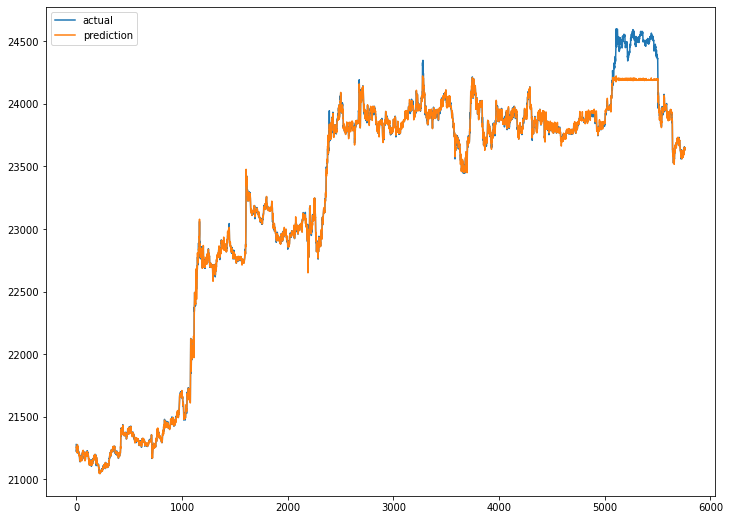

In [10]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test), label='actual')
plt.plot(pred, label='prediction')
plt.legend()

plt.show()

## BentoML

In [11]:
import bentoml
bento_model = bentoml.xgboost.save_model("xgb_bento", model)

In [12]:
xgb_bento = bentoml.xgboost.load_model("xgb_bento:latest")
xgb_bento.predict(xgb.DMatrix([[21195.60, 21205.46, 21187.19, 78.80792]]))

array([21199.11], dtype=float32)

### Serving

In [14]:
from bentoml.io import NumpyNdarray

In [16]:
runner =  bentoml.xgboost.get("xgb_bento:latest").to_runner()

In [17]:
svc = bentoml.Service("xgb_bento", runners=[runner])

@svc.api(input=NumpyNdarray(), output=NumpyNdarray())
def predict(input_series: np.ndarray) -> np.ndarray:
    result = runner.predict.run(input_series)
    return result

In [1]:
import requests

In [3]:
requests.post(
    "http://127.0.0.1:3000/predict",
    headers={"content-type": "application/json"},
    data="[[21195.60, 21205.46, 21187.19, 78.80792]]").text

'[21199.109375]'

In [5]:
requests.post(
    "http://0.0.0.0:3000/predict",
    headers={"content-type": "application/json"},
    data="[[21195.60, 21205.46, 21187.19, 78.80792]]").text

'[21199.109375]'